# Task 2 : DQN Agent 

## Resources
https://github.com/sudharsan13296/Hands-On-Reinforcement-Learning-With-Python/blob/master/08.%20Atari%20Games%20with%20DQN/8.8%20Building%20an%20Agent%20to%20Play%20Atari%20Games.ipynb
 
https://github.com/chengxi600/RLStuff/blob/master/Q%20Learning/Atari_DQN.ipynb

https://medium.com/nerd-for-tech/reinforcement-learning-deep-q-learning-with-atari-games-63f5242440b1

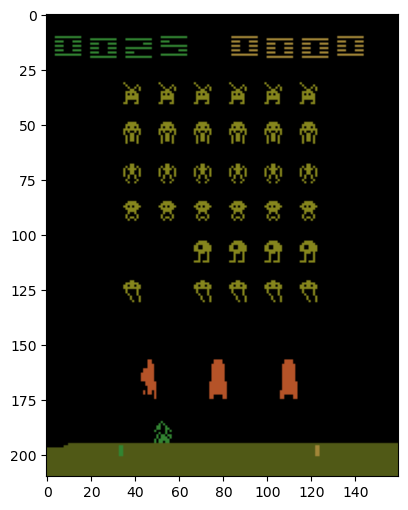

In [ ]:
import matplotlib.pyplot as plt
import gym
from IPython import display

env = gym.make('SpaceInvaders-v4')
env.reset()

fig = plt.figure(figsize=(6, 6))

for i in range(1000):
    obs = env.render(mode='rgb_array')
    plt.imshow(obs)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    env.step(env.action_space.sample()) # take a random action
    
env.close()


The reward in the OpenAI gym environment "SpaceInvaders-v4" is defined as follows:

+1 is awarded for each alien that is shot.
-1 is awarded for each time a player's ship is hit by an alien's bomb.
+100 is awarded for each time a player's ship reaches the bottom of the screen.
The goal of the agent is to maximize the cumulative reward, which is equivalent to shooting as many aliens as possible and avoiding being hit by their bombs.

In [ ]:
import random
import numpy as np
import tensorflow as tf
from collections import deque
from gym import wrappers
import gym
import pickle

# Hyperparameters
#learning_rate = 0.00025
learning_rate = 0.001
discount_factor = 0.99
exploration_max = 1.0
exploration_min = 0.01
exploration_decay = 0.995 # this decay rate is probably too slow

# Initialize the environment
env = gym.make('SpaceInvaders-v4')

# Neural Network Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 8, 4, input_shape=(84, 84, 4)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 4, 2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, 1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(env.action_space.n, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

# Memory
memory = deque(maxlen=10000)

# preprocess the frame
def preprocess_frame(frame):
    gray = tf.image.rgb_to_grayscale(frame)
    resized = tf.image.resize(gray, [84, 84])
    return np.array(resized)

# choose the next action
def choose_action(state, exploration_rate):
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    q_values = model.predict(state)
    return np.argmax(q_values[0])

# store the experience in the memory
def store_experience(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

# learn from the experiences
def experience_replay(batch_size):
    # Check if there are enough memories stored
    if len(memory) < batch_size:
        return
    #sample a batch of memories
    samples = random.sample(memory, batch_size)
    # update values for each memory iteration
    for state, action, reward, next_state, done in samples:
        q_update = reward
        if not done:
            next_state = next_state.reshape(1, 84, 84, 4)
            #Calculate the discounted future reward
            q_update = (reward + discount_factor * np.amax(model.predict(next_state)[0]))
        state = state.reshape(1, 84, 84, 4)
         # Get the current Q-values for the state 
        q_values = model.predict(state)
        # Update the Q-value for the chosen action 
        q_values[0][action] = q_update
        # Fit the model to the updated Q-values S/A
        model.fit(state, q_values, verbose=0)

# update the exploration rate
def update_exploration_rate(exploration_rate):
    return max(exploration_min, exploration_rate * exploration_decay)

# Training
total_steps = 0
exploration_rate = exploration_max
# List to store total rewards for each episode
rewards = []

#List to store exploration rate for each episode
exploration_rates = []

# Warm-up period
# Collect experiences without learning from them until the memory buffer is filled
warmup_steps = 100
while len(memory) < warmup_steps:
    state = env.reset()
    state = preprocess_frame(state)
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0

    while not done:
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_max)
        next_state, reward, done,_ = env.step(action)
        next_state = preprocess_frame(next_state)
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        store_experience(state, action, reward, next_state, done)
        state = next_state
        total_steps += 1


for episode in range(1, 5000):
    state = env.reset() # reset state
    state = preprocess_frame(state) # process frames
    # Stack the preprocessed state 4 times
    state = np.stack([state] * 4, axis=2)
    done = False
    total_reward = 0
    
    while not done:
        #choose action
        action = choose_action(state.reshape(1, 84, 84, 4), exploration_rate)
        # take step action and observe outcome 
        next_state, reward, done, _ = env.step(action)
        # process next state
        next_state = preprocess_frame(next_state)
        # concatenate to last 3 states to create new state stack
        next_state = np.concatenate((next_state.reshape(84, 84, 1), state[:, :, :3].reshape(84, 84, 3)), axis=2)
        total_reward += reward
        # add experience to the buffer
        store_experience(state, action, reward, next_state, done)
        state = next_state
        # update the Q-network by replaying batch of experiences
        experience_replay(batch_size=2000) 
        total_steps += 1
        
    exploration_rate = update_exploration_rate(exploration_rate)        
    print("Episode: {}/{}, Exploration rate: {:.4f}, Total reward: {}".format(episode, 5000, exploration_rate, total_reward))

    # Append the total reward and exploration rate for this episode to the respective lists
    rewards.append(total_reward)
    exploration_rates.append(exploration_rate)
        

    env.close()

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step
Episode: 942/5000, Exploration rate: 0.0100, Total reward: 25.0
1/1 [==============================] - 0s 19ms/step
Episode: 943/5000, Exploration rate: 0.0100, Total reward: 10.0
1/1 [==============================] - 0s 24ms/step
Episode: 944/5000, Exploration rate: 0.0100, Total reward: 30.0
1/1 [==============================] - 0s 21ms/step
Episode: 945/5000, Exploration rate: 0.0100, Total reward: 5.0
1/1 [==============================] - 0s 20ms/step
Episode: 946/5000, Exploration rate: 0.0100, Total reward: 30.0
1/1 [==============================] - 0s 19ms/step
Episode: 947/5000, Exploration rate: 0.0100, Total reward: 10.0
1/1 [==============================] - 0s 26ms/step
Episode: 948/5000, Exploration rate: 0.0100, Total reward: 15.0
1/1 [==============================] - 0s 19ms/step


possible that the increasing RAM usage is due to a memory leak in the code which could be the accumulation of TensorFlow graphs in memory. Clearing the TensorFlow graph at the end of each episode to try and solve the high ram issue

a low batch size results in the experience replay getting stuck in that state and unable to complete an episode while having a deque that can store too many experiences can impact performace due to ram and cause a crash

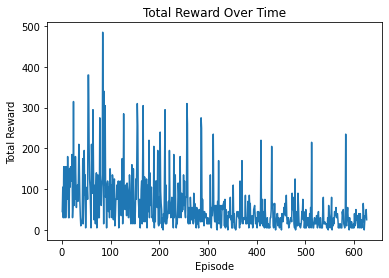

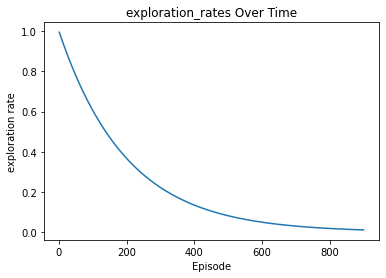

900


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Plot the total reward over time
plt.plot(range(1, len(rewards)+1), rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Over Time")
plt.show()


# Plot the exploration rate over time
plt.plot(range(1, len(exploration_rates)+1), exploration_rates)
plt.xlabel("Episode")
plt.ylabel("exploration rate")
plt.title("exploration_rates Over Time")
plt.show()

print(episode)